In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.colors as col
import sys
sys.path.append('/pool/firebolt1/p484/projects/huang/rings')
from continuumanalysis3 import Continuum
from fitellipse import *

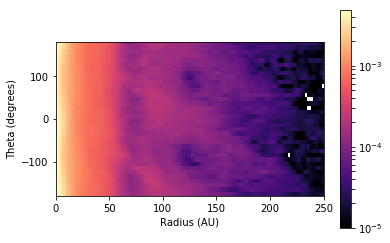

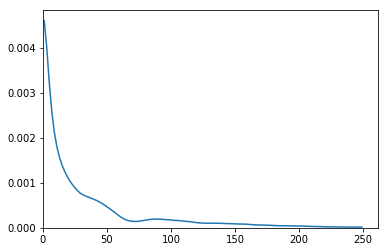

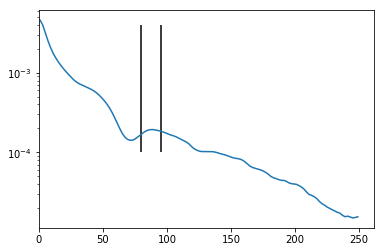

In [2]:
disk = {'filename': '/data/sandrews/jhfiles/LPfiles/taperedimages/Elias27_lowgain.image.fits',
                          'distance':116,
                          'incl' : 57.2,
                          'PA' : 118.4,
                          'offsetx' : .31*.003,
                          'offsety' : -1.6*.003,
                          'size': 4,
                          'gamma': 0.5
                         }

cont = Continuum(disk['filename'], disk['offsetx'],disk['offsety'], disk['PA'], disk['incl'], disk['distance'])
maxrad = 250
radialbins = 1+2*np.arange(125)
surfbrightness, SB_scatter, rtmap = cont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

plt.imshow(rtmap,extent =[0, np.max(radialbins)+1, -180,180], 
#           aspect = 0.4, origin = 'lower', cmap = 'magma', norm = col.PowerNorm(gamma = 0.4))\
           aspect = 0.4, origin = 'lower', cmap = 'magma', norm = col.LogNorm(vmin = 1.e-5))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()

plt.plot(radialbins, surfbrightness)
plt.xlim(xmin = 0)
plt.ylim(ymin =0)

plt.show()


plt.semilogy(radialbins, surfbrightness)
plt.vlines(80, 1.e-4, .004)
plt.vlines(95,1.e-4,.004)
plt.xlim(xmin = 0)
plt.show()



/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):


The MLE offsets are delta_x = -5.726e-03 arcsec, delta_y = -7.407e-03 arcsec
The MLE semi-major axis is r = 0.602 arcsec
The MLE inclination is i = 56.646 degrees
The MLE position angle is PA = 118.557 degrees
The MLE log-variance in the pixel offsets from the true ellipse is -8.534e+00


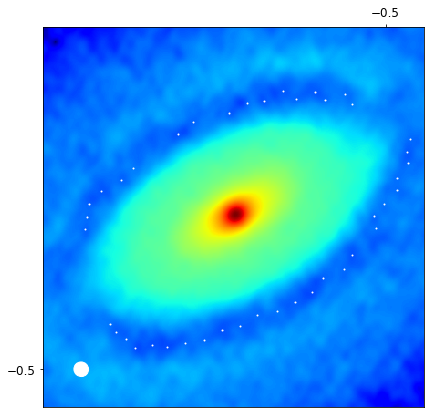

In [3]:


# Extract the gap that's at ~70 AU
xcoords1, ycoords1 = cont.extract_ring(65,75,
                                       tbins = np.concatenate((-177+6*np.arange(11),  -88+6*np.arange(27),123+6*np.arange(10))),
                                                                     extract_type = 'min')

cont.plot_extracted_ring(cont,xcoords1, ycoords1, 0.4, 1.25, cmap = 'jet')

#get maximum likelihood estimates and check that ellipse parameters seem reasonable
mle_1 = ellipse_mle([disk["offsetx"],
                     disk["offsety"],
                     70/116.,
                     np.cos(disk["incl"]*np.pi/180.),
                     disk["PA"]*np.pi/180., 
                     np.log(.01**2)], 
                    xcoords1, ycoords1)


In [4]:
#do mcmc fit
def lnprior(ellipse_params):
    x0, y0, r0, cosi, par, logvar = ellipse_params
    if -4.5 < x0 < 4.5 and -4.5 < y0 < 4.5 and 0 < r0 < 4.5 and -1<cosi<1 and 0 < par < np.pi and -12<logvar<-6:
        return 0.0
    return -np.inf

def lnprob(ellipse_params, xcoord, ycoord):
    lp = lnprior(ellipse_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(ellipse_params, xcoord, ycoord)

nwalkers = 100
nthreads = 8
nsteps = 1000
sampler1 = run_mcmc(nwalkers, nthreads, nsteps, mle_1, lnprob, xcoords1, ycoords1)

/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float64):
/pool/firebolt1/p484/projects/huang/rings/fitellipse.py:59: ComplexWarning: Casting complex values to real discards the imaginary part
  for dx in roots[np.where(np.isreal(roots))].astype(np.float

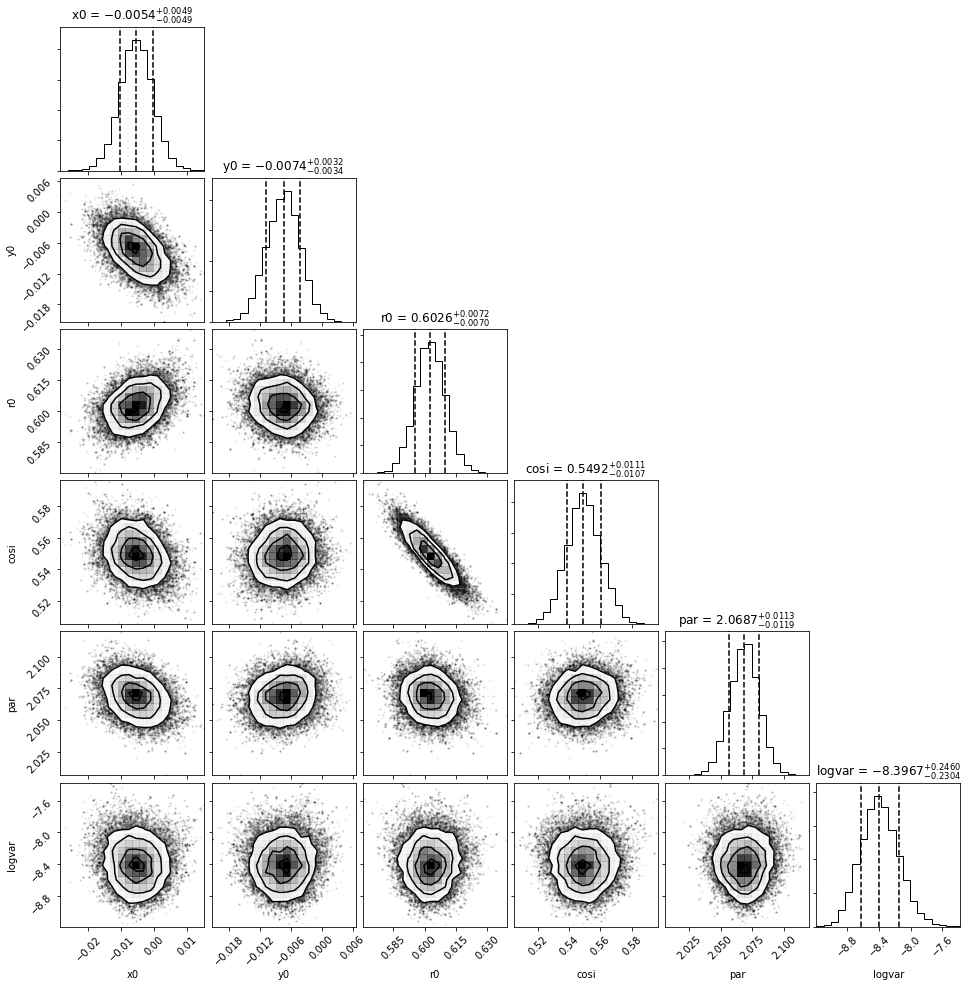

The x offset is delta_x = -5.40e-03 arcsec (+4.9e-03, -4.9e-03)
The y offset is delta_y = -7.40e-03 arcsec (+3.2e-03, -3.4e-03)
The median semi-major axis is r = 0.6026 arcsec (+0.0072, -0.0070) 
or 69.91 AU (+0.37, -0.40)
The incl is i = 56.69 deg (+0.73, -0.77)
The median position angle is PA = 118.52 deg (+0.65, -0.68)
The median log-variance in the pixel offsets from the true ellipse is -8.397e+00


In [5]:


plot_corner(sampler1, 500, 1)
sampler_results(sampler1, 500, cont.src_distance)


In [6]:

maxrad = 250
radialbins = 0.5+np.arange(0, maxrad)
#make some preliminary plots
newcont = Continuum(disk['filename'], -0.0063,-0.0074, 118.7, 55.9,disk['distance'])
    
newsurfbrightness, newSB_scatter, newrtmap = newcont.azunwrap(radialbins, tbins = -175 + 10.*np.arange(36))

print("max",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'max'))
print("min",find_profile_extrema(radialbins, newsurfbrightness, extrema = 'min'))

max [86, 128, 233, 239]
min [70, 128, 231, 239, 244]


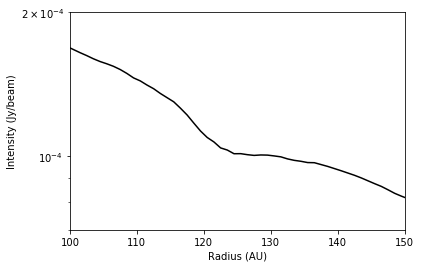

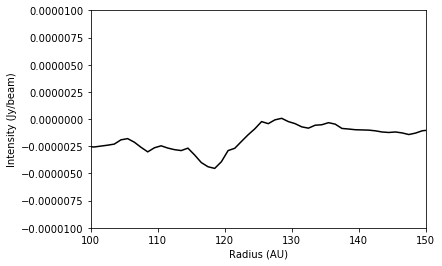

[ -2.56630157e-06  -2.48535812e-06  -2.40206045e-06  -2.30199316e-06
  -1.90930347e-06  -1.79773539e-06  -2.12789158e-06  -2.59703560e-06
  -3.01490060e-06  -2.63875161e-06  -2.45931529e-06  -2.66700127e-06
  -2.81334021e-06  -2.89674217e-06  -2.67334789e-06  -3.30168418e-06
  -4.00044237e-06  -4.38453427e-06  -4.53654903e-06  -3.92232420e-06
  -2.89616219e-06  -2.68530898e-06  -2.05311516e-06  -1.43889280e-06
  -8.91477843e-07  -2.31923969e-07  -4.20739768e-07  -6.99167235e-08
   6.90453546e-08  -2.31518868e-07  -4.19340502e-07  -7.14889826e-07
  -8.34558542e-07  -5.65852860e-07  -5.20681317e-07  -3.29831660e-07
  -4.67318461e-07  -8.61620656e-07  -9.14528385e-07  -9.79290539e-07
  -9.93843657e-07  -1.01613892e-06  -1.07990793e-06  -1.18789594e-06
  -1.23191167e-06  -1.18506934e-06  -1.27512520e-06  -1.42136294e-06
  -1.28723481e-06  -1.07551314e-06]


(array([ 70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,
         83,  84,  85,  86, 128, 167, 223, 231, 232, 239, 244, 245, 246,
        247, 248, 249]),)

In [7]:
plt.semilogy(radialbins, newsurfbrightness, color = 'black')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 100, xmax = 150)
plt.ylim(ymin = 7.e-5, ymax = 2.e-4)
plt.show()

plt.plot(radialbins, np.gradient(newsurfbrightness), color = 'black')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 100, xmax = 150)
plt.ylim(ymin = -1.e-5, ymax = 1.e-5)
plt.show()

print(np.gradient(newsurfbrightness)[100:150])
np.where(np.gradient(newsurfbrightness)>-2.e-8)

/home/janehuan/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:1115: RuntimeWarning: invalid value encountered in power
  np.power(resdat, gamma, resdat)


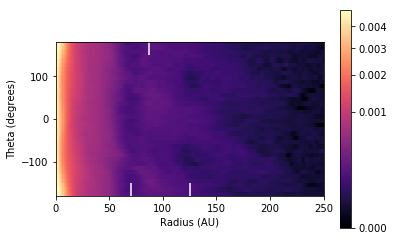

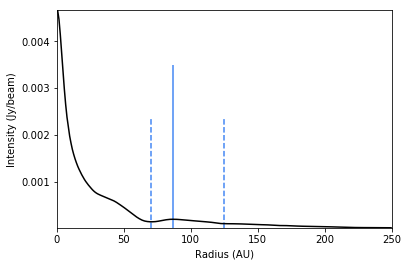

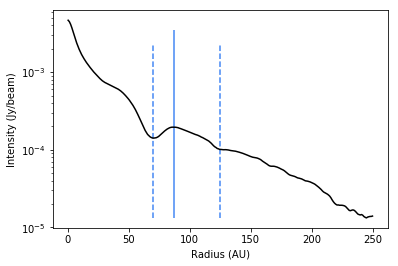

(0, 250)

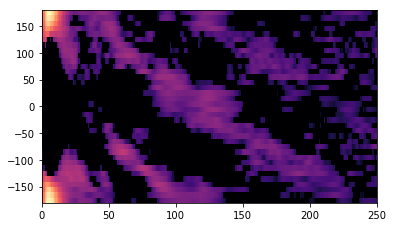

In [9]:
plt.imshow(newrtmap,extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.4))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
gaps = np.array([70, 125])
rings = np.array([87])
for gap in gaps:
    plt.vlines(gap,-180,-150, color ='white')
for ring in rings:
    plt.vlines(ring,150,180, color ='white')
plt.colorbar()
plt.xlabel('Radius (AU)')
plt.ylabel('Theta (degrees)')
plt.show()


plt.plot(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.xlim(xmin = 0, xmax = maxrad)
plt.ylim(ymin = np.min(newsurfbrightness), ymax = np.max(newsurfbrightness))
plt.show()

plt.semilogy(radialbins, newsurfbrightness, color = 'black')
for gap in gaps:
    plt.vlines(gap,np.min(newsurfbrightness),0.5*np.max(newsurfbrightness), color ='#4286f4', linestyles= 'dashed')
for ring in rings:
    plt.vlines(ring,np.min(newsurfbrightness),0.75*np.max(newsurfbrightness), color ='#4286f4')
plt.xlabel("Radius (AU)")
plt.ylabel("Intensity (Jy/beam)")
plt.show()

plt.imshow(newrtmap-np.mean(newrtmap, axis =0),extent =[0, np.max(radialbins)+1, -180,180], 
           aspect = 0.4, origin = 'lower', cmap = 'magma', vmin = 0, norm = col.PowerNorm(gamma = 0.3))
plt.ylim(ymin = -180, ymax = 180)
plt.xlim(xmin=0, xmax=maxrad)
plt.xlim(xmin=0, xmax=maxrad)
